## Creating a Simple 0-D Box Model

### Introduction

The following Python code shows you how a very simple box model can be created and solved numerically (i.e., calculated forward in time using discrete time steps). In this model, we will simulate the night time loss of O$_3$ and related chemical species. 

For this, let us consider the following eight reactions, each with their own known rate coefficient, *k$_i$*:

R1&emsp;  NO + O$_3$ &#8594; NO$_2$ + O$_2$

R2&emsp;  NO$_2$ + O$_3$ &#8594; NO$_3$ + O$_2$

R3&emsp;  NO$_2$ + NO$_3$ &#8594; 2 NO$_2$

R4&emsp;  NO$_2$ + NO$_3$ + M &#8594; N$_2$O$_5$ + M

R5&emsp;  N$_2$O$_5$ + M &#8594; NO$_2$ + NO$_3$ + M

R6&emsp;  N$_2$O$_5$ + H$_2$O + Surface &#8594; *products*

R7&emsp;  O$_3$ + VOCs &#8594; *products*

R8&emsp;  NO$_3$ + VOCs &#8594; *products*

### Importing Python Dependencies

One of the powerful aspects of Python is that there are a number of supporting libraries that can be imported to support your coding. Two popular packages include the *numpy* package (which provides sophisticated support for array mathematics), and the *matplotlib* package (which provides excellent basic support for plotting). Before we start anything, we must import these packages into our Python session. One nice feature is that you can "rename" a package during import so that when you must call it in your code, you can use a convenient shortform. 

In [11]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt

### Model Set Up

We are now ready to set up our model. The first thing we can do is set the initial concentrations (i.e. at *time = 0*) that we are going to model forward. Of course, while it is convenient to provide our concentrations in the familiar units of "ppb" or "ppt", for kinetics calculations we will need to convert these values into units of molecues/cm$^3$.

In [12]:
# Initial gas species concentrations (at time = 0)
NO_ppb   = 0 # initial NO concentrations in ppb
NO2_ppb  = 15 # initial NO2 concentration in ppb
O3_ppb   = 50 # initial O3 concentration in ppb
NO3_ppb  = 0 # initial NO3 concentration in ppb
N2O5_ppb = 0 # initial N2O5 concentration in ppb

# Convert initial concentrations to molecules/cm3
ppb2molec = 10**-9*2.46E19 # unit conversion from ppb to molec/cm3
NO_i   = NO_ppb*ppb2molec
NO2_i  = NO2_ppb*ppb2molec
O3_i   = O3_ppb*ppb2molec
NO3_i  = NO3_ppb*ppb2molec
N2O5_i = N2O5_ppb*ppb2molec

Next, let us provide the rate coefficients for all the reactions we are going to include in our model. The units of our rate coefficients will be in cm$^3$ molecule$^{-1}$ s$^{-1}$ for bimolecular reactions, and s$^{-1}$ for pseudo first order reactions (e.g. the loss of O$_3$ and NO$_3$ to some mixture of VOCs). Note, we will only consider the high pressure limit forms of any termolecular reactions so that they also appear as bimolecular. 

In [13]:
# What reactions are we going to include?
k1 = 1.8E-14 # NO + O3 --> NO2 + O2
k2 = 3.5E-17 # NO2 + O3 --> NO3 + O2
k3 = 2.6E-11 # NO + NO3 --> 2 NO2
k4 = 1.9E-12 # NO2 + NO3 + M --> N2O5
k5 = 6.9E-2  # N2O5 + M --> NO2
k6 = 0.005   # N2O5 + H2O + surf --> products
k7 = 1.0E-5  # O3 + VOC --> products
k8 = 0.25    # NO3 + VOC --> products

Let us decide on our model time step. If you do not choose a small enough timestep (i.e. quite a bit smaller than the lifetime of your most short-lived species), then your numerical model can crash very quickly. We can also decide on our model run time.

In [14]:
# Model timestep:
timestep = 0.5 # unit of seconds 

# Model time
runtime = 8  # total run time in hours
time_n = int(runtime*3600/timestep)
modeltime = np.arange(time_n)*timestep/3600

We could also consider some primary emissions of NO, which would be common at night time in an urban environment.

In [15]:
# Emissions of NO
E_NO = 1.0E+7 # Emissions of NO in molecues/cm3/s

Finally, let's set up some empty arrays to store the model output. We will store the output for five species: NO, NO$_2$, O$_3$, NO$_3$, and N$_2$O$_5$.

In [16]:
# Make empty arrays to store model output
NO   = np.zeros(time_n)
NO2  = np.zeros(time_n)
O3   = np.zeros(time_n)
NO3  = np.zeros(time_n)
N2O5 = np.zeros(time_n)

### Running the Model

Now we are ready to run our numerical model! 

To do this, we will create a loop that will step forward over discrete increments of time (defined by the variable *timestep* above), and calculate the instantaneous rate of change for each individual chemical species by accounting for all the formation and loss reactions involved. The rate of change for each individual species at each discrete time step will then be added to the concentration of the species from the preceding time step.

So, for example, considering the rate of change of NO at some particular timestep, we would have:

\begin{equation*}
\frac{d[NO]}{dt}=E_{NO} -k_2[NO][O_3]-k_1[NO][NO_3]
\end{equation*}

so that calculating the new concentration of NO becomes:

\begin{equation*}
[NO]_t=[NO]_{t-1} + \frac{d[NO]}{dt}.
\end{equation*}

We simply have to solve all these equations for every chemical species in our mechanism, at every time step, and store the output in an array. 

In [17]:
# Loop through time steps
for i in range(time_n):
    
    if i == 0: 
                       
        # initialize the output arrays with the given initial concentrations:
        NO[0] = NO_i 
        NO2[0] = NO2_i
        O3[0] = O3_i 
        NO3[0] = NO3_i 
        N2O5[0] = N2O5_i
       
    else: 
          
        # Calculate the change in concentrations over each timestep:    
        dNO = (E_NO -k1*NO[i-1]*O3[i-1] - k3*NO[i-1]*NO3[i-1])*timestep
        dNO2 = (k1*NO[i-1]*O3[i-1] + k5*N2O5[i-1] + 2*k3*NO[i-1]*NO3[i-1] - k2*NO2[i-1]*O3[i-1] - k4*NO2[i-1]*NO3[i-1])*timestep
        dO3 = (-k7*O3[i-1] - k1*NO[i-1]*O3[i-1] - k2*NO2[i-1]*O3[i-1])*timestep
        dNO3 = (k2*NO2[i-1]*O3[i-1] + k5*N2O5[i-1] - k3*NO[i-1]*NO3[i-1] - k8*NO3[i-1] - k4*NO2[i-1]*NO3[i-1])*timestep
        dN2O5 = (k4*NO2[i-1]*NO3[i-1] - k5*N2O5[i-1] - k6*N2O5[i-1])*timestep
                
        # Now calculate the new concentration of each species, and store in the output arrays.
        # If the rate of change would make the concentration negative, set to zero.
        if NO[i-1] + dNO >= 0:
            NO[i] = NO[i-1] + dNO
        else:
            NO[i] = 0
        
        if NO2[i-1] + dNO2 >= 0:
            NO2[i] = NO2[i-1] + dNO2
        else: 
            NO2[i] = 0
            
        if O3[i-1] + dO3 >= 0:
            O3[i] = O3[i-1] + dO3
        else: 
            O3[i] = 0
            
        if NO3[i-1] + dNO3 >= 0:
            NO3[i] = NO3[i-1] + dNO3
        else: 
            NO3[i] = 0
        
        if N2O5[i-1] + dN2O5 >= 0:
            N2O5[i] = N2O5[i-1] + dN2O5     
        else:
            N2O5[i] = 0

### Plotting the Model Output

Now we are ready to explore the model output. Let's first convert our concentration output (which will be in units of molecules cm$^-3$) into ppb for NO, NO$_2$, and O$_3$, and into ppt for NO$_3$ and N$_2$O$_5$.

In [18]:
NO   = NO/2.46E19*10**9
NO2  = NO2/2.46E19*10**9
O3   = O3/2.46E19*10**9
NO3  = NO3/2.46E19*10**12
N2O5 = N2O5/2.46E19*10**12

Now we are ready to make plots!

Model Output Plot:


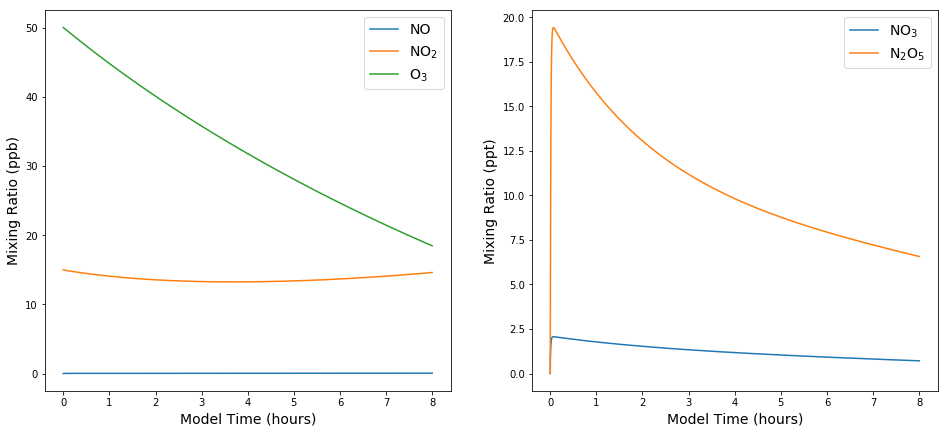

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

ax1.plot(modeltime, NO, label='NO')
ax1.plot(modeltime, NO2, label='NO$_2$')
ax1.plot(modeltime, O3, label='O$_3$')
lgnd = ax1.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=14)
lgnd.legendHandles[0]._legmarker.set_markersize(5)
ax1.set_xlabel('Model Time (hours)', fontsize=14)
ax1.set_ylabel('Mixing Ratio (ppb)', fontsize=14) 

ax2.plot(modeltime, NO3, label='NO$_3$')
ax2.plot(modeltime, N2O5, label='N$_2$O$_5$')
lgnd = ax2.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=14)
lgnd.legendHandles[0]._legmarker.set_markersize(5)
ax2.set_xlabel('Model Time (hours)', fontsize=14)
ax2.set_ylabel('Mixing Ratio (ppt)', fontsize=14) 

print("Model Output Plot:")

Let's print the model output at the last element.

In [20]:
print('\033[1m'+'\033[4m'+'Model Output at time = '+f'{modeltime[-1]:.0f}'+' hours:'+'\033[0m')
print("NO   = \t"+f'{NO[-1]:.2f}'+' ppb')
print("NO2  = \t"+f'{NO2[-1]:.2f}'+' ppb')
print("O3   = \t"+f'{O3[-1]:.2f}'+' ppb:')
print("NO3  = \t"+f'{NO3[-1]:.2f}'+' ppt:')
print("N2O5 = \t"+f'{N2O5[-1]:.2f}'+' ppt:')

Model Output at time = 8 hours:
NO   = 	0.05 ppb
NO2  = 	14.60 ppb
O3   = 	18.46 ppb:
NO3  = 	0.71 ppt:
N2O5 = 	6.57 ppt:
